# 日経平均株価 日足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '^N225'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1y')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-06 00:00:00+09:00,32928.921875,33452.128906,32914.089844,33445.898438,91200000,0.0,0.0
2023-12-07 00:00:00+09:00,33165.718750,33195.871094,32814.691406,32858.308594,105100000,0.0,0.0
2023-12-08 00:00:00+09:00,32600.470703,32604.349609,32205.380859,32307.859375,144200000,0.0,0.0
2023-12-11 00:00:00+09:00,32665.089844,32933.078125,32650.099609,32791.800781,105800000,0.0,0.0
2023-12-12 00:00:00+09:00,33107.648438,33172.128906,32800.238281,32843.699219,98100000,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-02 00:00:00+09:00,38216.949219,38552.410156,37958.550781,38513.019531,110500000,0.0,0.0
2024-12-03 00:00:00+09:00,38748.648438,39427.371094,38746.050781,39248.859375,142200000,0.0,0.0
2024-12-04 00:00:00+09:00,39354.000000,39417.078125,39062.031250,39276.390625,119100000,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

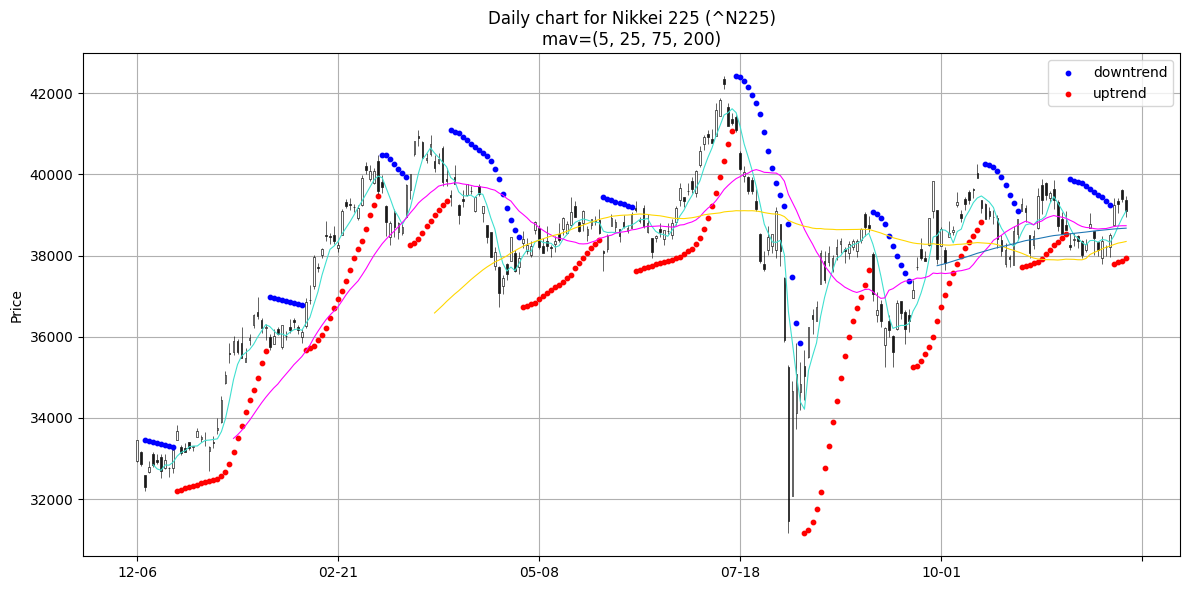

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75, 200),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75, 200)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75, 200)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_n225.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-12-05 00:00:00+09:00    39395.601562
2024-12-06 00:00:00+09:00    39091.171875
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-12-05 00:00:00+09:00           NaN
2024-12-06 00:00:00+09:00   -304.429688
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(25).mean()

Date
2023-12-06 00:00:00+09:00             NaN
2023-12-07 00:00:00+09:00             NaN
2023-12-08 00:00:00+09:00             NaN
2023-12-11 00:00:00+09:00             NaN
2023-12-12 00:00:00+09:00             NaN
                                 ...     
2024-12-02 00:00:00+09:00    38691.736719
2024-12-03 00:00:00+09:00    38717.469844
2024-12-04 00:00:00+09:00    38732.378281
2024-12-05 00:00:00+09:00    38737.106719
2024-12-06 00:00:00+09:00    38737.503594
Name: Close, Length: 247, dtype: float64

In [7]:
df['Close'].rolling(75).mean()

Date
2023-12-06 00:00:00+09:00             NaN
2023-12-07 00:00:00+09:00             NaN
2023-12-08 00:00:00+09:00             NaN
2023-12-11 00:00:00+09:00             NaN
2023-12-12 00:00:00+09:00             NaN
                                 ...     
2024-12-02 00:00:00+09:00    38237.622812
2024-12-03 00:00:00+09:00    38275.041875
2024-12-04 00:00:00+09:00    38309.038542
2024-12-05 00:00:00+09:00    38326.810937
2024-12-06 00:00:00+09:00    38349.511615
Name: Close, Length: 247, dtype: float64

In [8]:
df['Close'].rolling(200).mean()

Date
2023-12-06 00:00:00+09:00             NaN
2023-12-07 00:00:00+09:00             NaN
2023-12-08 00:00:00+09:00             NaN
2023-12-11 00:00:00+09:00             NaN
2023-12-12 00:00:00+09:00             NaN
                                 ...     
2024-12-02 00:00:00+09:00    38646.135361
2024-12-03 00:00:00+09:00    38657.892549
2024-12-04 00:00:00+09:00    38664.454658
2024-12-05 00:00:00+09:00    38672.916064
2024-12-06 00:00:00+09:00    38677.582217
Name: Close, Length: 247, dtype: float64